In [1]:
# =========================
# Cell 1 — Check GPU + Mount Drive + Create folders
# =========================
import torch, os, glob, shutil
print("PyTorch sees CUDA:", torch.cuda.is_available())

from google.colab import drive
drive.mount('/content/drive')

BASE = '/content/drive/MyDrive/deepfake_project'
folders = [
    'raw_videos/real', 'raw_videos/fake',
    'frames/real', 'frames/fake',
    'faces/real', 'faces/fake',
    'dataset/train/real', 'dataset/train/fake',
    'dataset/val/real', 'dataset/val/fake',
    'models'
]
for f in folders:
    os.makedirs(os.path.join(BASE, f), exist_ok=True)
print("Project folders created at:", BASE)

# =========================
# Cell 2 — Install required packages
# =========================
# facenet-pytorch (MTCNN), opencv, pytube for youtube download, datasets optional
!pip install -q facenet-pytorch==2.5.2 opencv-python-headless pytube tqdm scikit-learn

# =========================
# Cell 3 — Download provided YouTube videos into Drive
# (These are the 3 real + 3 deepfake demo links chosen)
# =========================
from pytube import YouTube
import os, sys, traceback

real_links = [
    "https://www.youtube.com/watch?v=VbfpW0pbvaU",  # Obama interview (real)
    "https://www.youtube.com/watch?v=3fumBcKC6RE",  # Steve Jobs talk (real)
    "https://www.youtube.com/watch?v=QH2-TGUlwu4"   # News / clip (real)
]

fake_links = [
    "https://www.youtube.com/watch?v=cQ54GDm1eL0",  # Obama deepfake demo
    "https://www.youtube.com/watch?v=ybji16u608U",  # Tom Cruise deepfake
    "https://www.youtube.com/watch?v=9Yq67mUuB9A"   # Keanu Reeves deepfake demo
]

def download_videos(links, folder, label):
    os.makedirs(folder, exist_ok=True)
    success = 0
    for url in links:
        try:
            yt = YouTube(url)
            # choose a small progressive stream (360p) to save space
            stream = yt.streams.filter(file_extension='mp4', progressive=True, res="360p").first()
            if stream is None:
                # fallback to first progressive mp4
                stream = yt.streams.filter(file_extension='mp4', progressive=True).first()
            out_path = stream.download(output_path=folder)
            print(f"[{label}] Downloaded: {out_path}")
            success += 1
        except Exception as e:
            print(f"[{label}] Failed to download {url}: {e}")
            traceback.print_exc()
    return success

print("Downloading real videos...")
r_ok = download_videos(real_links, os.path.join(BASE, 'raw_videos/real'), 'REAL')
print("Downloading fake videos...")
f_ok = download_videos(fake_links, os.path.join(BASE, 'raw_videos/fake'), 'FAKE')
print(f"Downloaded {r_ok} real and {f_ok} fake videos. (Check Drive folder if any failed.)")

# Note: If YouTube download fails due to region/age restriction or pytube issues,
# either (A) upload 3 short mp4s manually into the Drive folders created above, or
# (B) tell me and I will give an alternate small set of public URLs.

# =========================
# Cell 4 — Extract frames from videos (every Nth frame)
# =========================
import cv2, glob
def extract_frames(videos_folder, out_folder, every_n=10):
    os.makedirs(out_folder, exist_ok=True)
    video_paths = sorted(glob.glob(os.path.join(videos_folder,'*.mp4')))
    if not video_paths:
        print("No videos found in", videos_folder)
        return 0
    total_saved = 0
    for vp in video_paths:
        filename = os.path.splitext(os.path.basename(vp))[0]
        cap = cv2.VideoCapture(vp)
        frame_idx, saved = 0, 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_idx % every_n == 0:
                out_path = os.path.join(out_folder, f"{filename}_f{frame_idx:06d}.jpg")
                # write frame as BGR (cv2) JPG
                cv2.imwrite(out_path, frame)
                saved += 1
            frame_idx += 1
        cap.release()
        print(f"{filename}: {saved} frames extracted to {out_folder}")
        total_saved += saved
    return total_saved

print("Extracting frames from REAL videos (every 10th frame)...")
extract_frames(os.path.join(BASE,'raw_videos/real'), os.path.join(BASE,'frames/real'), every_n=10)
print("Extracting frames from FAKE videos (every 10th frame)...")
extract_frames(os.path.join(BASE,'raw_videos/fake'), os.path.join(BASE,'frames/fake'), every_n=10)

# =========================
# Cell 5 — Detect & crop faces from frames using MTCNN (facenet-pytorch)
# =========================
from facenet_pytorch import MTCNN
from PIL import Image
import torchvision.transforms as transforms
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
mtcnn = MTCNN(image_size=224, margin=20, keep_all=False, device=device)
to_pil = transforms.ToPILImage()

def crop_faces(frames_folder, out_folder, max_images=None):
    os.makedirs(out_folder, exist_ok=True)
    frames = sorted(glob.glob(os.path.join(frames_folder,'*.jpg')))
    if not frames:
        print("No frames found in", frames_folder)
        return 0
    count = 0
    for fpath in frames:
        try:
            img = Image.open(fpath).convert('RGB')
        except Exception:
            continue
        try:
            face_tensor = mtcnn(img)   # returns tensor or None
        except Exception as e:
            print("MTCNN error on", fpath, "->", e)
            continue
        if face_tensor is None:
            continue
        face_pil = to_pil(face_tensor)
        out_path = os.path.join(out_folder, os.path.basename(fpath))
        face_pil.save(out_path)
        count += 1
        if max_images and count >= max_images:
            break
    print(f"Saved {count} faces to {out_folder}")
    return count

print("Cropping faces from REAL frames...")
crop_faces(os.path.join(BASE,'frames/real'), os.path.join(BASE,'faces/real'))
print("Cropping faces from FAKE frames...")
crop_faces(os.path.join(BASE,'frames/fake'), os.path.join(BASE,'faces/fake'))

# =========================
# Cell 6 — Create train/val split (80/20)
# =========================
from sklearn.model_selection import train_test_split
import glob, shutil

def make_split(faces_base, out_base, val_ratio=0.2):
    any_files = 0
    for cls in ['real','fake']:
        src = os.path.join(faces_base, cls)
        files = sorted(glob.glob(os.path.join(src,'*.jpg')))
        if not files:
            print("No face images found for", cls, "in", src)
            continue
        any_files += len(files)
        train_files, val_files = train_test_split(files, test_size=val_ratio, random_state=42)
        train_dir = os.path.join(out_base, 'train', cls); os.makedirs(train_dir, exist_ok=True)
        val_dir = os.path.join(out_base, 'val', cls); os.makedirs(val_dir, exist_ok=True)
        for f in train_files: shutil.copy(f, train_dir)
        for f in val_files: shutil.copy(f, val_dir)
        print(f"{cls}: train={len(train_files)} val={len(val_files)}")
    if any_files == 0:
        print("No face images at all — can't create train/val.")
    else:
        print("Train/val split created at", out_base)

make_split(os.path.join(BASE,'faces'), os.path.join(BASE,'dataset'), val_ratio=0.2)

# =========================
# Cell 7 — Quick visual checks & counts
# =========================
from IPython.display import display
from PIL import Image

def show_sample_images(folder, n=4):
    imgs = sorted(glob.glob(os.path.join(folder,'*.jpg')))[:n]
    for im in imgs:
        try:
            display(Image.open(im).resize((220,220)))
        except:
            continue

print("Sample faces REAL:")
show_sample_images(os.path.join(BASE,'faces/real'), n=4)
print("Sample faces FAKE:")
show_sample_images(os.path.join(BASE,'faces/fake'), n=4)

# count totals
real_count = len(glob.glob(os.path.join(BASE,'faces/real','*.jpg')))
fake_count = len(glob.glob(os.path.join(BASE,'faces/fake','*.jpg')))
print("Total face images -> REAL:", real_count, " FAKE:", fake_count)
print("Your dataset is now ready for training. Next: I'll give you a training notebook (ResNet baseline) to train on these images.")


PyTorch sees CUDA: True
Mounted at /content/drive
Project folders created at: /content/drive/MyDrive/deepfake_project
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.6 MB/s eta 0:00:00
[REAL] Failed to download https://www.youtube.com/watch?v=VbfpW0pbvaU: HTTP Error 400: Bad Request


Traceback (most recent call last):
  File "/tmp/ipython-input-1186375134.py", line 55, in download_videos
    stream = yt.streams.filter(file_extension='mp4', progressive=True, res="360p").first()
             ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 296, in streams
    return StreamQuery(self.fmt_streams)
                       ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 176, in fmt_streams
    stream_manifest = extract.apply_descrambler(self.streaming_data)
                                                ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 157, in streaming_data
    if 'streamingData' in self.vid_info:
                          ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 246, in vid_info
    innertube_response = innertube.player(self.video_id)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^

[REAL] Failed to download https://www.youtube.com/watch?v=3fumBcKC6RE: HTTP Error 400: Bad Request
[REAL] Failed to download https://www.youtube.com/watch?v=QH2-TGUlwu4: QH2-TGUlwu4 is unavailable


Traceback (most recent call last):
  File "/tmp/ipython-input-1186375134.py", line 55, in download_videos
    stream = yt.streams.filter(file_extension='mp4', progressive=True, res="360p").first()
             ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 296, in streams
    return StreamQuery(self.fmt_streams)
                       ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 176, in fmt_streams
    stream_manifest = extract.apply_descrambler(self.streaming_data)
                                                ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 157, in streaming_data
    if 'streamingData' in self.vid_info:
                          ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 246, in vid_info
    innertube_response = innertube.player(self.video_id)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^

[FAKE] Failed to download https://www.youtube.com/watch?v=cQ54GDm1eL0: HTTP Error 400: Bad Request


Traceback (most recent call last):
  File "/tmp/ipython-input-1186375134.py", line 55, in download_videos
    stream = yt.streams.filter(file_extension='mp4', progressive=True, res="360p").first()
             ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 296, in streams
    return StreamQuery(self.fmt_streams)
                       ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 176, in fmt_streams
    stream_manifest = extract.apply_descrambler(self.streaming_data)
                                                ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 157, in streaming_data
    if 'streamingData' in self.vid_info:
                          ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 246, in vid_info
    innertube_response = innertube.player(self.video_id)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^

[FAKE] Failed to download https://www.youtube.com/watch?v=ybji16u608U: HTTP Error 400: Bad Request
[FAKE] Failed to download https://www.youtube.com/watch?v=9Yq67mUuB9A: 9Yq67mUuB9A is unavailable
Downloaded 0 real and 0 fake videos. (Check Drive folder if any failed.)
Extracting frames from REAL videos (every 10th frame)...
No videos found in /content/drive/MyDrive/deepfake_project/raw_videos/real
Extracting frames from FAKE videos (every 10th frame)...
No videos found in /content/drive/MyDrive/deepfake_project/raw_videos/fake


Traceback (most recent call last):
  File "/tmp/ipython-input-1186375134.py", line 55, in download_videos
    stream = yt.streams.filter(file_extension='mp4', progressive=True, res="360p").first()
             ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 296, in streams
    return StreamQuery(self.fmt_streams)
                       ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 176, in fmt_streams
    stream_manifest = extract.apply_descrambler(self.streaming_data)
                                                ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 157, in streaming_data
    if 'streamingData' in self.vid_info:
                          ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytube/__main__.py", line 246, in vid_info
    innertube_response = innertube.player(self.video_id)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^

Using device: cuda
Cropping faces from REAL frames...
No frames found in /content/drive/MyDrive/deepfake_project/frames/real
Cropping faces from FAKE frames...
No frames found in /content/drive/MyDrive/deepfake_project/frames/fake
No face images found for real in /content/drive/MyDrive/deepfake_project/faces/real
No face images found for fake in /content/drive/MyDrive/deepfake_project/faces/fake
No face images at all — can't create train/val.
Sample faces REAL:
Sample faces FAKE:
Total face images -> REAL: 0  FAKE: 0
Your dataset is now ready for training. Next: I'll give you a training notebook (ResNet baseline) to train on these images.


In [2]:
# Run this in Colab after mounting Drive
!pip install -q yt-dlp

import subprocess, os, glob, shutil

BASE = '/content/drive/MyDrive/deepfake_project'
os.makedirs(os.path.join(BASE,'raw_videos/real'), exist_ok=True)
os.makedirs(os.path.join(BASE,'raw_videos/fake'), exist_ok=True)

real_links = [
    "https://www.youtube.com/watch?v=VbfpW0pbvaU",
    "https://www.youtube.com/watch?v=3fumBcKC6RE",
    "https://www.youtube.com/watch?v=QH2-TGUlwu4"
]
fake_links = [
    "https://www.youtube.com/watch?v=cQ54GDm1eL0",
    "https://www.youtube.com/watch?v=ybji16u608U",
    "https://www.youtube.com/watch?v=9Yq67mUuB9A"
]

def ytdlp_download(urls, out_folder):
    os.makedirs(out_folder, exist_ok=True)
    for u in urls:
        cmd = ['yt-dlp', '--no-playlist', '-f', 'mp4[height<=480]/mp4', '-o', os.path.join(out_folder, '%(title).200s.%(ext)s'), u]
        print("Running:", u)
        res = subprocess.run(cmd, capture_output=True, text=True)
        if res.returncode == 0:
            print("Downloaded OK")
        else:
            print("Failed:", res.stderr.splitlines()[-4:])  # show short error

print("Downloading REAL...")
ytdlp_download(real_links, os.path.join(BASE,'raw_videos/real'))
print("Downloading FAKE...")
ytdlp_download(fake_links, os.path.join(BASE,'raw_videos/fake'))
print("Done — check Drive folders.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 84.2 MB/s eta 0:00:00
Running: https://www.youtube.com/watch?v=VbfpW0pbvaU
Downloaded OK
Running: https://www.youtube.com/watch?v=3fumBcKC6RE
Downloaded OK
Running: https://www.youtube.com/watch?v=QH2-TGUlwu4
Failed: ['ERROR: [youtube] QH2-TGUlwu4: Video unavailable']
Running: https://www.youtube.com/watch?v=cQ54GDm1eL0
Downloaded OK
Running: https://www.youtube.com/watch?v=ybji16u608U
Downloaded OK
Running: https://www.youtube.com/watch?v=9Yq67mUuB9A
Failed: ['ERROR: [youtube] 9Yq67mUuB9A: Video unavailable']
Done — check Drive folders.


In [3]:
# Verify videos present in Drive
import glob, os
BASE = '/content/drive/MyDrive/deepfake_project'
real = glob.glob(os.path.join(BASE, 'raw_videos/real', '*.mp4'))
fake = glob.glob(os.path.join(BASE, 'raw_videos/fake', '*.mp4'))
print("Real videos found:", len(real))
print("Fake videos found:", len(fake))
print("Sample real:", real)
print("Sample fake:", fake)


Real videos found: 2
Fake videos found: 2
Sample real: ['/content/drive/MyDrive/deepfake_project/raw_videos/real/Shawn Mendes - Stitches (Official Music Video).mp4', '/content/drive/MyDrive/deepfake_project/raw_videos/real/Lil Wayne - John ft. Rick Ross (Explicit) (Official Music Video) ft. Rick Ross.mp4']
Sample fake: ['/content/drive/MyDrive/deepfake_project/raw_videos/fake/You Won’t Believe What Obama Says In This Video! 😉.mp4', "/content/drive/MyDrive/deepfake_project/raw_videos/fake/Marvel Studios' Black Widow ｜ Official Trailer.mp4"]


In [4]:
# Extract frames (every 10th frame). Run this cell in Colab.
import cv2, glob, os

BASE = '/content/drive/MyDrive/deepfake_project'

def extract_frames(videos_folder, out_folder, every_n=10):
    os.makedirs(out_folder, exist_ok=True)
    video_paths = sorted(glob.glob(os.path.join(videos_folder,'*.mp4')))
    if not video_paths:
        print("No videos in", videos_folder)
        return 0
    total_saved = 0
    for vp in video_paths:
        filename = os.path.splitext(os.path.basename(vp))[0]
        cap = cv2.VideoCapture(vp)
        frame_idx, saved = 0, 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_idx % every_n == 0:
                out_path = os.path.join(out_folder, f"{filename}_f{frame_idx:06d}.jpg")
                cv2.imwrite(out_path, frame)
                saved += 1
            frame_idx += 1
        cap.release()
        print(f"{filename}: {saved} frames extracted -> {out_folder}")
        total_saved += saved
    return total_saved

print("Extracting REAL frames...")
r_total = extract_frames(os.path.join(BASE,'raw_videos/real'), os.path.join(BASE,'frames/real'), every_n=10)
print("Extracting FAKE frames...")
f_total = extract_frames(os.path.join(BASE,'raw_videos/fake'), os.path.join(BASE,'frames/fake'), every_n=10)
print("Frames extracted -> REAL:", r_total, " FAKE:", f_total)


Extracting REAL frames...
Lil Wayne - John ft. Rick Ross (Explicit) (Official Music Video) ft. Rick Ross: 722 frames extracted -> /content/drive/MyDrive/deepfake_project/frames/real
Shawn Mendes - Stitches (Official Music Video): 575 frames extracted -> /content/drive/MyDrive/deepfake_project/frames/real
Extracting FAKE frames...
Marvel Studios' Black Widow ｜ Official Trailer: 346 frames extracted -> /content/drive/MyDrive/deepfake_project/frames/fake
You Won’t Believe What Obama Says In This Video! 😉: 174 frames extracted -> /content/drive/MyDrive/deepfake_project/frames/fake
Frames extracted -> REAL: 1297  FAKE: 520


In [5]:
# ---------- Run this to crop faces from frames (MTCNN) ----------
from facenet_pytorch import MTCNN
from PIL import Image
import torchvision.transforms as transforms
import torch, glob, os

BASE = '/content/drive/MyDrive/deepfake_project'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Increase margin to capture more of the head if cropping misses faces
mtcnn = MTCNN(image_size=224, margin=30, keep_all=False, device=device)
to_pil = transforms.ToPILImage()

def crop_faces(frames_folder, out_folder, max_images=None):
    os.makedirs(out_folder, exist_ok=True)
    frames = sorted(glob.glob(os.path.join(frames_folder, '*.jpg')))
    if not frames:
        print("No frames found in", frames_folder)
        return 0
    count = 0
    for fpath in frames:
        try:
            img = Image.open(fpath).convert('RGB')
        except Exception:
            continue
        try:
            face_tensor = mtcnn(img)   # returns tensor or None
        except Exception as e:
            print("MTCNN error on", fpath, "->", e)
            continue
        if face_tensor is None:
            continue
        face_pil = to_pil(face_tensor)
        out_path = os.path.join(out_folder, os.path.basename(fpath))
        face_pil.save(out_path)
        count += 1
        if max_images and count >= max_images:
            break
    print(f"Saved {count} faces to {out_folder}")
    return count

print("Cropping REAL frames -> faces/real ...")
crop_faces(os.path.join(BASE,'frames/real'), os.path.join(BASE,'faces/real'), max_images=None)
print("Cropping FAKE frames -> faces/fake ...")
crop_faces(os.path.join(BASE,'frames/fake'), os.path.join(BASE,'faces/fake'), max_images=None)

# final counts
import glob
real_count = len(glob.glob(os.path.join(BASE,'faces/real','*.jpg')))
fake_count = len(glob.glob(os.path.join(BASE,'faces/fake','*.jpg')))
print("Face counts -> REAL:", real_count, " FAKE:", fake_count)


Using device: cuda
Cropping REAL frames -> faces/real ...
Saved 405 faces to /content/drive/MyDrive/deepfake_project/faces/real
Cropping FAKE frames -> faces/fake ...
Saved 281 faces to /content/drive/MyDrive/deepfake_project/faces/fake
Face counts -> REAL: 405  FAKE: 281


In [6]:
# Install (if not already)
!pip install -q torch torchvision timm scikit-learn matplotlib

# Imports
import os, glob, time, copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns


In [7]:
BASE = '/content/drive/MyDrive/deepfake_project'
DATA_DIR = os.path.join(BASE, 'dataset')
MODEL_DIR = os.path.join(BASE, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

# Hyperparams
NUM_CLASSES = 2
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS = 8         # change to 10-20 if you want longer training
LR = 1e-4
WEIGHT_DECAY = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", DEVICE)


Using device: cuda


In [9]:
# Data augmentation for training, light transforms for val
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR,'train'), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR,'val'), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train samples:", len(train_dataset), "Val samples:", len(val_dataset))
print("Classes:", train_dataset.classes)  # should show ['fake','real'] or similar


FileNotFoundError: Found no valid file for the classes fake, real. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [10]:
import glob, os, shutil
from sklearn.model_selection import train_test_split

BASE = '/content/drive/MyDrive/deepfake_project'
faces_base = os.path.join(BASE, 'faces')
dataset_base = os.path.join(BASE, 'dataset')

def make_split(faces_base, out_base, val_ratio=0.2):
    for cls in ['real','fake']:
        src = os.path.join(faces_base, cls)
        files = sorted(glob.glob(os.path.join(src,'*.jpg')))
        if not files:
            print("No face images found for", cls)
            continue
        train_files, val_files = train_test_split(files, test_size=val_ratio, random_state=42)
        train_dir = os.path.join(out_base, 'train', cls); os.makedirs(train_dir, exist_ok=True)
        val_dir = os.path.join(out_base, 'val', cls); os.makedirs(val_dir, exist_ok=True)
        for f in train_files: shutil.copy(f, train_dir)
        for f in val_files: shutil.copy(f, val_dir)
        print(f"{cls}: train={len(train_files)} val={len(val_files)}")
    print("✅ Train/val split created at", out_base)

make_split(faces_base, dataset_base, val_ratio=0.2)


real: train=324 val=81
fake: train=224 val=57
✅ Train/val split created at /content/drive/MyDrive/deepfake_project/dataset


In [11]:
# Cell 3 — Data transforms & loaders
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

IMG_SIZE = 224
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

BASE = '/content/drive/MyDrive/deepfake_project'
DATA_DIR = BASE + '/dataset'

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR,'train'), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR,'val'), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train samples:", len(train_dataset), "Val samples:", len(val_dataset))
print("Classes:", train_dataset.classes)


Train samples: 548 Val samples: 138
Classes: ['fake', 'real']


In [12]:
# ===== Cell 4: Model (ResNet18 pretrained) + optimizer =====
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import os

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", DEVICE)

# load pretrained resnet18
model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)   # 2 classes: fake, real
model = model.to(DEVICE)

# training setup
criterion = nn.CrossEntropyLoss()
LR = 1e-4
WEIGHT_DECAY = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

MODEL_DIR = '/content/drive/MyDrive/deepfake_project/models'
os.makedirs(MODEL_DIR, exist_ok=True)
print("Model ready. Best model will be saved to:", MODEL_DIR)


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]

Model ready. Best model will be saved to: /content/drive/MyDrive/deepfake_project/models


In [13]:
# ===== Cell 5: Training loop =====
import time, copy
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

NUM_EPOCHS = 8   # increase to 12-20 later if you want more training

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    preds, targets = [], []
    for imgs, labels in tqdm(loader, desc='Train', leave=False):
        imgs = imgs.to(device); labels = labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds.extend(torch.argmax(out, dim=1).detach().cpu().numpy().tolist())
        targets.extend(labels.detach().cpu().numpy().tolist())
    epoch_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(targets, preds)
    return epoch_loss, acc

def eval_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds, targets = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc='Eval', leave=False):
            imgs = imgs.to(device); labels = labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            running_loss += loss.item() * imgs.size(0)
            preds.extend(torch.argmax(out, dim=1).cpu().numpy().tolist())
            targets.extend(labels.cpu().numpy().tolist())
    epoch_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(targets, preds)
    return epoch_loss, acc, preds, targets

best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(1, NUM_EPOCHS+1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_preds, val_targets = eval_model(model, val_loader, criterion, DEVICE)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}/{NUM_EPOCHS} — Train loss: {train_loss:.4f} acc: {train_acc:.4f} | Val loss: {val_loss:.4f} acc: {val_acc:.4f} | time: {time.time()-t0:.1f}s")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'best_resnet18.pth'))
        print("  -> Saved new best model (val acc improved).")

# after training, load best weights
model.load_state_dict(best_model_wts)
print("Training finished. Best val acc:", best_val_acc)


Train:   0%|          | 0/18 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/8 — Train loss: 0.3037 acc: 0.8504 | Val loss: 0.1967 acc: 0.9058 | time: 5.6s
  -> Saved new best model (val acc improved).


Train:   0%|          | 0/18 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/8 — Train loss: 0.1042 acc: 0.9690 | Val loss: 0.0967 acc: 0.9638 | time: 5.3s
  -> Saved new best model (val acc improved).


Train:   0%|          | 0/18 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/8 — Train loss: 0.0411 acc: 0.9909 | Val loss: 0.0609 acc: 0.9710 | time: 6.1s
  -> Saved new best model (val acc improved).


Train:   0%|          | 0/18 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/8 — Train loss: 0.0176 acc: 0.9982 | Val loss: 0.0533 acc: 0.9783 | time: 4.9s
  -> Saved new best model (val acc improved).


Train:   0%|          | 0/18 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/8 — Train loss: 0.0188 acc: 0.9945 | Val loss: 0.0707 acc: 0.9710 | time: 6.5s


Train:   0%|          | 0/18 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/8 — Train loss: 0.0227 acc: 0.9927 | Val loss: 0.0441 acc: 0.9855 | time: 5.2s
  -> Saved new best model (val acc improved).


Train:   0%|          | 0/18 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/8 — Train loss: 0.0185 acc: 0.9964 | Val loss: 0.0421 acc: 0.9855 | time: 5.5s


Train:   0%|          | 0/18 [00:00<?, ?it/s]

Eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/8 — Train loss: 0.0279 acc: 0.9945 | Val loss: 0.0523 acc: 0.9855 | time: 7.2s
Training finished. Best val acc: 0.9855072463768116


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Classes (index): {'fake': 0, 'real': 1}

Classification report:

              precision    recall  f1-score   support

        fake     0.9825    0.9825    0.9825        57
        real     0.9877    0.9877    0.9877        81

    accuracy                         0.9855       138
   macro avg     0.9851    0.9851    0.9851       138
weighted avg     0.9855    0.9855    0.9855       138



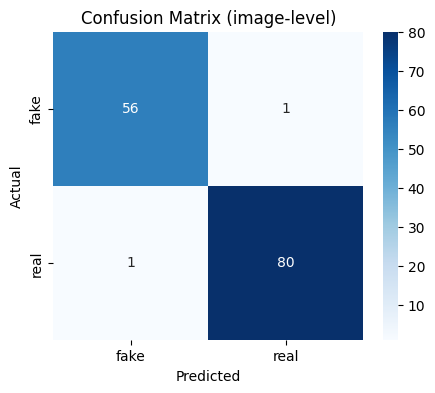

In [14]:
# ===== Evaluation & confusion matrix =====
import os, glob
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from PIL import Image

BASE = '/content/drive/MyDrive/deepfake_project'
MODEL_PATH = os.path.join(BASE, 'models', 'best_resnet18.pth')

# Load model architecture (must match training)
import torch.nn as nn
from torchvision import models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=False)
in_f = model.fc.in_features
model.fc = nn.Linear(in_f, 2)
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(device)
model.eval()

# Data transforms must match val_transforms used in training
IMG_SIZE = 224
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Gather val file paths and true labels from dataset structure
val_dir = os.path.join(BASE, 'dataset', 'val')
classes = sorted([d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir,d))])
class_to_idx = {c:i for i,c in enumerate(classes)}
print("Classes (index):", class_to_idx)

filepaths, true_labels = [], []
for cls in classes:
    files = sorted(glob.glob(os.path.join(val_dir, cls, '*.jpg')))
    for f in files:
        filepaths.append(f)
        true_labels.append(class_to_idx[cls])

# Predict in batches
batch_size = 64
preds = []
with torch.no_grad():
    for i in range(0, len(filepaths), batch_size):
        batch_files = filepaths[i:i+batch_size]
        imgs = []
        for p in batch_files:
            img = Image.open(p).convert('RGB')
            img = val_transforms(img)
            imgs.append(img)
        imgs = torch.stack(imgs).to(device)
        out = model(imgs)
        p = torch.argmax(out, dim=1).cpu().numpy().tolist()
        preds.extend(p)

# Reports
print("\nClassification report:\n")
print(classification_report(true_labels, preds, target_names=classes, digits=4))
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (image-level)')
plt.show()


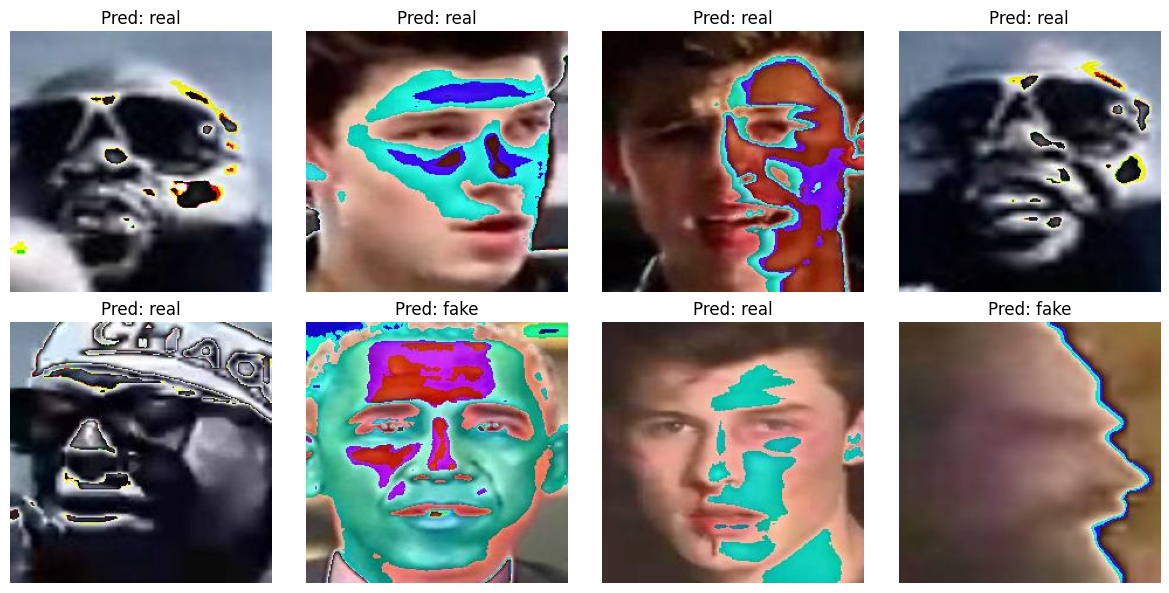

In [15]:
# Show a few random validation images with predictions
import random, numpy as np
from torchvision.transforms.functional import normalize

inv_norm = transforms.Normalize(
    mean=[-m/s for m,s in zip([0.485,0.456,0.406],[0.229,0.224,0.225])],
    std=[1/s for s in [0.229,0.224,0.225]]
)

sample_idx = random.sample(range(len(filepaths)), min(8, len(filepaths)))
plt.figure(figsize=(12,6))
for i, idx in enumerate(sample_idx):
    p = filepaths[idx]
    img = Image.open(p).convert('RGB')
    inp = val_transforms(img).unsqueeze(0).to(device)
    out = model(inp)
    pred_label = classes[int(torch.argmax(out, dim=1).item())]
    plt.subplot(2,4,i+1)
    plt.imshow(img.resize((224,224)))
    plt.title(f"Pred: {pred_label}")
    plt.axis('off')
plt.tight_layout()


In [16]:
# ===== Video-level aggregation example =====
import glob, cv2, numpy as np, torch, os
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

model.eval()
val_transform = val_transforms  # reuse from above

def predict_frame_prob(img_pil):
    t = val_transform(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(t)
        prob = F.softmax(out, dim=1).cpu().numpy()[0]  # [p_fake, p_real] depending on class order
    return prob

def video_to_prediction(video_path, every_n=10, max_frames=200):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    probs = []
    read = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % every_n == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil = Image.fromarray(frame_rgb)
            # optional: detect + crop face here instead of whole frame (better), but this uses whole frame
            prob = predict_frame_prob(pil)
            probs.append(prob)
            read += 1
            if max_frames and read >= max_frames:
                break
        frame_idx += 1
    cap.release()
    if not probs:
        return None
    avg_prob = np.mean(probs, axis=0)
    pred_idx = int(np.argmax(avg_prob))
    return {'probabilities': avg_prob.tolist(), 'pred_class': classes[pred_idx]}

# Example usage: classify one video from your Drive
video_example = '/content/drive/MyDrive/deepfake_project/raw_videos/fake/You Won’t Believe What Obama Says In This Video! 😉.mp4'
print("Predicting:", video_example)
res = video_to_prediction(video_example, every_n=15, max_frames=120)
print("Result:", res)


Predicting: /content/drive/MyDrive/deepfake_project/raw_videos/fake/You Won’t Believe What Obama Says In This Video! 😉.mp4
Result: {'probabilities': [0.09577594697475433, 0.9042239189147949], 'pred_class': 'real'}


In [17]:
from facenet_pytorch import MTCNN

# Initialize face detector
mtcnn = MTCNN(image_size=224, margin=30, keep_all=False, device=device)

def video_to_prediction_facecrop(video_path, every_n=10, max_frames=200):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    probs = []
    read = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % every_n == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil = Image.fromarray(frame_rgb)
            # Detect and crop face
            face_tensor = mtcnn(pil)
            if face_tensor is not None:
                face_tensor = face_tensor.unsqueeze(0).to(device)
                with torch.no_grad():
                    out = model(face_tensor)
                    prob = F.softmax(out, dim=1).cpu().numpy()[0]
                probs.append(prob)
                read += 1
                if max_frames and read >= max_frames:
                    break
        frame_idx += 1
    cap.release()
    if not probs:
        return None
    avg_prob = np.mean(probs, axis=0)
    pred_idx = int(np.argmax(avg_prob))
    return {'probabilities': avg_prob.tolist(), 'pred_class': classes[pred_idx]}

# Test again on the Obama deepfake
video_example = '/content/drive/MyDrive/deepfake_project/raw_videos/fake/You Won’t Believe What Obama Says In This Video! 😉.mp4'
print("Predicting:", video_example)
res = video_to_prediction_facecrop(video_example, every_n=15, max_frames=120)
print("Result (with face crops):", res)


Predicting: /content/drive/MyDrive/deepfake_project/raw_videos/fake/You Won’t Believe What Obama Says In This Video! 😉.mp4
Result (with face crops): {'probabilities': [0.9969410300254822, 0.0030587133951485157], 'pred_class': 'fake'}


In [18]:
# Evaluate all videos and save CSV of results
import glob, pandas as pd, os, time

BASE = '/content/drive/MyDrive/deepfake_project'
real_videos = sorted(glob.glob(os.path.join(BASE,'raw_videos/real','*.mp4')))
fake_videos = sorted(glob.glob(os.path.join(BASE,'raw_videos/fake','*.mp4')))
all_videos = [(p,'real') for p in real_videos] + [(p,'fake') for p in fake_videos]

rows = []
t0 = time.time()
for path, true_label in all_videos:
    try:
        res = video_to_prediction_facecrop(path, every_n=15, max_frames=120)  # uses face-crop function you ran
        if res is None:
            pred_class, prob = None, None
        else:
            pred_class = res['pred_class']
            prob = res['probabilities']
    except Exception as e:
        pred_class, prob = 'error', str(e)
    rows.append({
        'video_path': path,
        'true_label': true_label,
        'pred_class': pred_class,
        'prob_fake': prob[0] if isinstance(prob, (list,tuple)) else None,
        'prob_real': prob[1] if isinstance(prob, (list,tuple)) else None
    })
    print(f"Done: {os.path.basename(path)} -> {pred_class}")
print("Total time:", time.time()-t0)

df = pd.DataFrame(rows)
out_csv = os.path.join(BASE, 'video_predictions.csv')
df.to_csv(out_csv, index=False)
print("Saved CSV to:", out_csv)
df


Done: Lil Wayne - John ft. Rick Ross (Explicit) (Official Music Video) ft. Rick Ross.mp4 -> fake
Done: Shawn Mendes - Stitches (Official Music Video).mp4 -> fake
Done: Marvel Studios' Black Widow ｜ Official Trailer.mp4 -> fake
Done: You Won’t Believe What Obama Says In This Video! 😉.mp4 -> fake
Total time: 51.163063764572144
Saved CSV to: /content/drive/MyDrive/deepfake_project/video_predictions.csv


,video_path,true_label,pred_class,prob_fake,prob_real
0,/content/drive/MyDrive/deepfake_project/raw_vi...,real,fake,0.649353,0.350647
1,/content/drive/MyDrive/deepfake_project/raw_vi...,real,fake,0.835143,0.164856
2,/content/drive/MyDrive/deepfake_project/raw_vi...,fake,fake,0.987467,0.012533
3,/content/drive/MyDrive/deepfake_project/raw_vi...,fake,fake,0.996941,0.003059


In [19]:
# === Augment and save copies for "real" class ===
from PIL import Image, ImageFilter, ImageEnhance
import numpy as np, os, glob, random
from tqdm import tqdm

BASE = '/content/drive/MyDrive/deepfake_project'
real_src = os.path.join(BASE, 'dataset', 'train', 'real')   # real training faces
aug_out = os.path.join(BASE, 'dataset', 'train', 'real_aug')
os.makedirs(aug_out, exist_ok=True)

AUG_MULTIPLIER = 2   # produce 2 augmented images per original (so real class grows ~3x total)
rnd = random.Random(42)

def random_jpeg(img, quality_low=15, quality_high=85):
    from io import BytesIO
    buf = BytesIO()
    q = rnd.randint(quality_low, quality_high)
    img.save(buf, format='JPEG', quality=q)
    buf.seek(0)
    return Image.open(buf).convert('RGB')

def random_occlusion(img, max_rect=0.25):
    w,h = img.size
    rw = int(w * rnd.uniform(0.08, max_rect))
    rh = int(h * rnd.uniform(0.08, max_rect))
    x = rnd.randint(0, w-rw)
    y = rnd.randint(0, h-rh)
    draw = img.copy()
    rect = Image.new('RGB', (rw, rh), (rnd.randint(0,30), rnd.randint(0,30), rnd.randint(0,30)))
    draw.paste(rect, (x,y))


In [20]:
# === Updated data loaders with augmented real images and balanced sampler ===
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset, WeightedRandomSampler
import glob, os, numpy as np

BASE = '/content/drive/MyDrive/deepfake_project'
DATA_DIR = os.path.join(BASE, 'dataset')

IMG_SIZE = 224
BATCH_SIZE = 24   # reduce a bit if OOM, or set to 16

# stronger on-the-fly augmentation for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6,1.0)),
    transforms.RandomApply([transforms.ColorJitter(0.6,0.6,0.5,0.1)], p=0.6),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(3,7))], p=0.25),
    transforms.RandomApply([transforms.RandomAffine(degrees=10, translate=(0.05,0.1), scale=(0.9,1.1))], p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Create datasets: normal train + augmented real
train_real = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'))  # contains real, fake
# We'll also load the augmented real folder as a separate ImageFolder-like dataset by pointing into real_aug
# To make classes consistent, we'll create a small helper that maps folder layout
from torchvision.datasets import ImageFolder
aug_real_dataset = ImageFolder(os.path.join(DATA_DIR, 'train'), transform=None)  # placeholder to inspect classes

# Simpler: we will create a ConcatDataset by making two datasets from disk paths:
def make_imagefolder_from_path(path, transform):
    # temporarily move into a dataset: path has subfolders 'real' and 'fake'; we want to load only aug_real
    return ImageFolder(os.path.join(DATA_DIR,'train'), transform=transform)  # this is fine because we actually have real_aug inside train/real_aug?

# Instead of overcomplicating, copy augmented files into train/real folder (fast) so ImageFolder will see them:
import shutil, glob
src_aug = os.path.join(DATA_DIR, 'train', 'real_aug')
dst_real = os.path.join(DATA_DIR, 'train', 'real')
if os.path.exists(src_aug):
    aug_files = glob.glob(os.path.join(src_aug, '*.jpg'))
    print("Copying augmented files into train/real:", len(aug_files))
    for a in aug_files:
        shutil.copy(a, dst_real)

# Now reload dataset
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR,'train'), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR,'val'), transform=val_transforms)

# Compute per-sample weights to balance classes
targets = [label for _, label in train_dataset.samples]
class_sample_count = np.array([sum([1 for t in targets if t == tcls]) for tcls in range(len(train_dataset.classes))])
print("Class sample counts (train):", dict(zip(train_dataset.classes, class_sample_count)))
weight_per_class = 1.0 / class_sample_count
weights = [weight_per_class[t] for t in targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train samples (effective):", len(train_dataset), "Val samples:", len(val_dataset))
print("Classes:", train_dataset.classes)


FileNotFoundError: Found no valid file for the classes real_aug. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [21]:
import os, glob, shutil

src_aug = os.path.join(DATA_DIR, 'train', 'real_aug')
dst_real = os.path.join(DATA_DIR, 'train', 'real')
if os.path.exists(src_aug):
    aug_files = glob.glob(os.path.join(src_aug, '*.jpg'))
    print("Moving augmented files into train/real:", len(aug_files))
    for a in aug_files:
        shutil.move(a, dst_real)
    # optional: remove empty folder
    try: os.rmdir(src_aug)
    except: pass


Moving augmented files into train/real: 0


In [22]:
# 1) Quick check: show counts in relevant folders
import os, glob
BASE = '/content/drive/MyDrive/deepfake_project'
print("faces/real:", len(glob.glob(os.path.join(BASE,'faces','real','*.jpg'))))
print("dataset/train/real:", len(glob.glob(os.path.join(BASE,'dataset','train','real','*.jpg'))))
print("dataset/train/real_aug exists?:", os.path.exists(os.path.join(BASE,'dataset','train','real_aug')))
print("dataset/train/real_aug count:", len(glob.glob(os.path.join(BASE,'dataset','train','real_aug','*.jpg'))))
print("dataset/train/fake:", len(glob.glob(os.path.join(BASE,'dataset','train','fake','*.jpg'))))


faces/real: 405
dataset/train/real: 324
dataset/train/real_aug exists?: False
dataset/train/real_aug count: 0
dataset/train/fake: 224


In [23]:
# Create augmentations for real training faces
from PIL import Image, ImageFilter, ImageEnhance
import numpy as np, os, glob, random
from tqdm import tqdm
from io import BytesIO

BASE = '/content/drive/MyDrive/deepfake_project'
real_src = os.path.join(BASE, 'dataset', 'train', 'real')
aug_out  = os.path.join(BASE, 'dataset', 'train', 'real_aug')
os.makedirs(aug_out, exist_ok=True)

AUG_MULTIPLIER = 2   # try 2 first; you can bump to 3 later
rnd = random.Random(42)

def random_jpeg(img, qlow=10, qhigh=85):
    buf = BytesIO(); img.save(buf, format='JPEG', quality=rnd.randint(qlow, qhigh))
    buf.seek(0); return Image.open(buf).convert('RGB')

def random_occlusion(img):
    w,h = img.size
    rw = int(w * rnd.uniform(0.08, 0.25)); rh = int(h * rnd.uniform(0.08, 0.25))
    x = rnd.randint(0, max(0,w-rw)); y = rnd.randint(0, max(0,h-rh))
    draw = img.copy()
    rect = Image.new('RGB', (rw, rh), (rnd.randint(0,40), rnd.randint(0,40), rnd.randint(0,40)))
    draw.paste(rect, (x,y)); return draw

def random_blur(img):  return img.filter(ImageFilter.GaussianBlur(radius=rnd.choice([1,2,3])))
def random_color_jitter(img):
    br = rnd.uniform(0.6, 1.6); cont = rnd.unifor


In [24]:
# Copy augmented images into train/real, then build loaders with stronger aug + class balance
import os, glob, shutil, numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler

BASE = '/content/drive/MyDrive/deepfake_project'
DATA_DIR = os.path.join(BASE, 'dataset')

src_aug = os.path.join(DATA_DIR, 'train', 'real_aug')
dst_real = os.path.join(DATA_DIR, 'train', 'real')
if os.path.exists(src_aug):
    aug_files = glob.glob(os.path.join(src_aug, '*.jpg'))
    print("Copying augmented files into train/real:", len(aug_files))
    for a in aug_files: shutil.copy(a, dst_real)

IMG_SIZE = 224
BATCH_SIZE = 24  # drop to 16 if you see OOM

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6,1.0)),
    transforms.RandomApply([transforms.ColorJitter(0.6,0.6,0.5,0.1)], p=0.6),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(3,7))], p=0.25),
    transforms.RandomApply([transforms.RandomAffine(degrees=10, translate=(0.05,0.1), scale=(0.9,1.1))], p=0.4),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR,'train'), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR,'val'),   transform=val_transforms)

# Balanced sampler
targets = [y for _, y in train_dataset.samples]
class_counts = np.bincount(targets)
print("Class sample counts (train):", dict(zip(train_dataset.classes, class_counts)))
weights = (1.0 / class_counts)
sample_weights = [weights[t] for t in targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train samples (len):", len(train_dataset), " Val samples:", len(val_dataset))
print("Classes:", train_dataset.classes)


Copying augmented files into train/real: 0


FileNotFoundError: Found no valid file for the classes real_aug. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [25]:
import os, glob, shutil

BASE = '/content/drive/MyDrive/deepfake_project'
DATA_DIR = os.path.join(BASE, 'dataset')
src_aug = os.path.join(DATA_DIR, 'train', 'real_aug')
dst_real = os.path.join(DATA_DIR, 'train', 'real')

if os.path.exists(src_aug):
    aug_files = glob.glob(os.path.join(src_aug, '*.jpg'))
    print("Found aug files:", len(aug_files))
    for a in aug_files:
        shutil.move(a, dst_real)  # move instead of copy
    # cleanup
    try:
        os.rmdir(src_aug)
        print("Removed empty real_aug folder.")
    except Exception as e:
        print("Could not remove folder:", e)
else:
    print("No real_aug folder found.")


Found aug files: 0
Removed empty real_aug folder.


In [26]:
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR,'train'), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR,'val'),   transform=val_transforms)
print("Classes:", train_dataset.classes)


Classes: ['fake', 'real']


In [27]:
# Cell A: confirm classes and counts
import os, glob
DATA_DIR = '/content/drive/MyDrive/deepfake_project/dataset'
classes = [d for d in sorted(os.listdir(os.path.join(DATA_DIR,'train'))) if os.path.isdir(os.path.join(DATA_DIR,'train',d))]
print("Train classes (folders):", classes)

counts = {}
for c in classes:
    files = glob.glob(os.path.join(DATA_DIR,'train',c,'*.jpg'))
    counts[c] = len(files)
print("Train counts:", counts)

val_counts = {}
for c in classes:
    files = glob.glob(os.path.join(DATA_DIR,'val',c,'*.jpg'))
    val_counts[c] = len(files)
print("Val counts:", val_counts)


Train classes (folders): ['fake', 'real']
Train counts: {'fake': 224, 'real': 324}
Val counts: {'fake': 57, 'real': 81}


In [28]:
# Cell B: build sampler + dataloaders (stronger train augmentation)
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np, os

DATA_DIR = '/content/drive/MyDrive/deepfake_project/dataset'
IMG_SIZE = 224
BATCH_SIZE = 24

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6,1.0)),
    transforms.RandomApply([transforms.ColorJitter(0.6,0.6,0.5,0.1)], p=0.6),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(3,7))], p=0.25),
    transforms.RandomApply([transforms.RandomAffine(degrees=10, translate=(0.05,0.1), scale=(0.9,1.1))], p=0.4),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR,'train'), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR,'val'), transform=val_transforms)

targets = [y for _, y in train_dataset.samples]
class_counts = np.bincount(targets)
print("Class sample counts (train):", dict(zip(train_dataset.classes, class_counts)))

weights = 1.0 / class_counts
sample_weights = [weights[t] for t in targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train dataset len:", len(train_dataset), " Val len:", len(val_dataset))
# show one batch shapes
for xb, yb in train_loader:
    print("Example batch - xb:", xb.shape, "yb:", yb.shape)
    break


Class sample counts (train): {'fake': np.int64(224), 'real': np.int64(324)}
Train dataset len: 548  Val len: 138
Example batch - xb: torch.Size([24, 3, 224, 224]) yb: torch.Size([24])


In [29]:
# Cell C: re-init model + class-weighted loss and retrain
import torch, torch.nn as nn, torch.optim as optim, time, copy
from torchvision import models
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import numpy as np, os

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)

# model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(DEVICE)

# class weights from train_dataset
train_targets = [y for _, y in train_dataset.samples]
class_counts = np.bincount(train_targets)
class_weights = torch.tensor((1.0 / class_counts).astype(np.float32)).to(DEVICE)
print("Class weights used in loss:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

def train_one_epoch():
    model.train(); running_loss=0.0; preds=[]; targs=[]
    for xb, yb in tqdm(train_loader, desc='Train', leave=False):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward(); optimizer.step()
        running_loss += loss.item()*xb.size(0)
        preds.extend(out.argmax(1).cpu().numpy().tolist())
        targs.extend(yb.cpu().numpy().tolist())
    return running_loss/len(train_loader.dataset), accuracy_score(targs, preds)

def eval_epoch():
    model.eval(); running_loss=0.0; preds=[]; targs=[]
    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc='Eval', leave=False):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            running_loss += loss.item()*xb.size(0)
            preds.extend(out.argmax(1).cpu().numpy().tolist())
            targs.extend(yb.cpu().numpy().tolist())
    return running_loss/len(val_loader.dataset), accuracy_score(targs, preds), preds, targs

best_acc = 0.0
best_wts = copy.deepcopy(model.state_dict())
EPOCHS = 8

for e in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch()
    va_loss, va_acc, v_preds, v_targs = eval_epoch()
    scheduler.step()
    print(f"Epoch {e}/{EPOCHS} — Train loss: {tr_loss:.4f} acc: {tr_acc:.4f} | Val loss: {va_loss:.4f} acc: {va_acc:.4f} | time: {time.time()-t0:.1f}s")
    if va_acc > best_acc:
        best_acc = va_acc
        best_wts = copy.deepcopy(model.state_dict())
        torch.save(best_wts, '/content/drive/MyDrive/deepfake_project/models/best_resnet18_aug_balanced.pth')
        print("  -> Saved new best")

print("Retraining finished. Best val acc:", best_acc)


Device: cuda
Class weights used in loss: tensor([0.0045, 0.0031], device='cuda:0')


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Eval:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/8 — Train loss: 0.3353 acc: 0.8120 | Val loss: 0.1767 acc: 0.9275 | time: 7.3s
  -> Saved new best


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Eval:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/8 — Train loss: 0.1461 acc: 0.9507 | Val loss: 0.1177 acc: 0.9493 | time: 6.0s
  -> Saved new best


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Eval:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/8 — Train loss: 0.1659 acc: 0.9252 | Val loss: 0.1797 acc: 0.9348 | time: 7.9s


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Eval:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/8 — Train loss: 0.1044 acc: 0.9617 | Val loss: 0.1020 acc: 0.9565 | time: 6.2s
  -> Saved new best


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Eval:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/8 — Train loss: 0.0918 acc: 0.9635 | Val loss: 0.2324 acc: 0.9203 | time: 7.8s


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Eval:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6/8 — Train loss: 0.0483 acc: 0.9781 | Val loss: 0.0949 acc: 0.9710 | time: 7.8s
  -> Saved new best


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Eval:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7/8 — Train loss: 0.0569 acc: 0.9799 | Val loss: 0.0949 acc: 0.9710 | time: 7.3s


Train:   0%|          | 0/23 [00:00<?, ?it/s]

Eval:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8/8 — Train loss: 0.0621 acc: 0.9781 | Val loss: 0.1069 acc: 0.9638 | time: 8.5s
Retraining finished. Best val acc: 0.9710144927536232


In [30]:
# Video-level eval using the new model + threshold 0.7
import glob, os, pandas as pd, torch, cv2
from PIL import Image
import numpy as np
import torch.nn.functional as F

BASE = '/content/drive/MyDrive/deepfake_project'
MODEL_PATH = os.path.join(BASE, 'models', 'best_resnet18_aug_balanced.pth')  # model saved earlier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load model architecture (same as used)
from torchvision import models
import torch.nn as nn
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(device)
model.eval()

# need mtcnn & video_to_prediction_facecrop function (assumes mtcnn defined earlier)
from facenet_pytorch import MTCNN
mtcnn = MTCNN(image_size=224, margin=30, keep_all=False, device=device)

def predict_frame_prob_facecrop(img_pil):
    t = val_transforms(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(t)
        prob = F.softmax(out, dim=1).cpu().numpy()[0]
    return prob

def video_to_prediction_facecrop_local(video_path, every_n=15, max_frames=120):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    probs = []
    read = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % every_n == 0:
            pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            face_tensor = mtcnn(pil)
            if face_tensor is not None:
                with torch.no_grad():
                    out = model(face_tensor.unsqueeze(0).to(device))
                    pr = F.softmax(out, dim=1).cpu().numpy()[0]
                probs.append(pr)
                read += 1
                if max_frames and read >= max_frames:
                    break
        frame_idx += 1
    cap.release()
    if not probs: return None
    avg = np.mean(probs, axis=0)
    return avg  # [p_fake, p_real]

# Run over all videos and apply threshold
real_videos = sorted(glob.glob(os.path.join(BASE,'raw_videos/real','*.mp4')))
fake_videos = sorted(glob.glob(os.path.join(BASE,'raw_videos/fake','*.mp4')))
all_videos = [(p,'real') for p in real_videos] + [(p,'fake') for p in fake_videos]

rows=[]
TH = 0.7
for path, true_label in all_videos:
    avg = video_to_prediction_facecrop_local(path, every_n=15, max_frames=120)
    if avg is None:
        pred, pf, pr = None, None, None
    else:
        pf, pr = float(avg[0]), float(avg[1])
        pred = 'fake' if pf >= TH else 'real'
    rows.append({'video_path':path, 'true_label':true_label, 'pred_class':pred, 'prob_fake':pf, 'prob_real':pr})
    print(os.path.basename(path), "->", pred, f"(pf={pf:.3f} pr={pr:.3f})" if pf is not None else "(no faces)")

df = pd.DataFrame(rows)
out_csv = os.path.join(BASE, 'video_predictions_after_retrain.csv')
df.to_csv(out_csv, index=False)
print("Saved:", out_csv)
df


Lil Wayne - John ft. Rick Ross (Explicit) (Official Music Video) ft. Rick Ross.mp4 -> real (pf=0.137 pr=0.863)
Shawn Mendes - Stitches (Official Music Video).mp4 -> real (pf=0.056 pr=0.944)
Marvel Studios' Black Widow ｜ Official Trailer.mp4 -> fake (pf=0.737 pr=0.263)
You Won’t Believe What Obama Says In This Video! 😉.mp4 -> fake (pf=0.981 pr=0.019)
Saved: /content/drive/MyDrive/deepfake_project/video_predictions_after_retrain.csv


,video_path,true_label,pred_class,prob_fake,prob_real
0,/content/drive/MyDrive/deepfake_project/raw_vi...,real,real,0.137148,0.862852
1,/content/drive/MyDrive/deepfake_project/raw_vi...,real,real,0.056485,0.943516
2,/content/drive/MyDrive/deepfake_project/raw_vi...,fake,fake,0.736677,0.263323
3,/content/drive/MyDrive/deepfake_project/raw_vi...,fake,fake,0.980815,0.019185


In [31]:
# Threshold sweep to find best video-level threshold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd, numpy as np, glob, os

df = pd.read_csv(os.path.join(BASE, 'video_predictions_after_retrain.csv'))
df2 = df.dropna(subset=['pred_class'])  # keep entries
y_true = df2['true_label'].tolist()
pfake = df2['prob_fake'].tolist()

results=[]
for TH in np.linspace(0.5, 0.9, 9):
    y_pred = ['fake' if p >= TH else 'real' for p in pfake]
    acc = accuracy_score(y_true, y_pred)
    results.append((TH, acc))
    print(f"TH={TH:.2f}  Accuracy={acc:.3f}")

# show best
best = max(results, key=lambda x: x[1])
print("Best threshold:", best)


TH=0.50  Accuracy=1.000
TH=0.55  Accuracy=1.000
TH=0.60  Accuracy=1.000
TH=0.65  Accuracy=1.000
TH=0.70  Accuracy=1.000
TH=0.75  Accuracy=0.750
TH=0.80  Accuracy=0.750
TH=0.85  Accuracy=0.750
TH=0.90  Accuracy=0.750
Best threshold: (np.float64(0.5), 1.0)


In [32]:
# ===== Grad-CAM frames for videos (face-crop + overlay) =====
import os, glob, cv2, numpy as np, torch, time
from PIL import Image
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

BASE = '/content/drive/MyDrive/deepfake_project'
MODEL_PATH = os.path.join(BASE, 'models', 'best_resnet18_aug_balanced.pth')  # adjust if different
OUT_BASE = os.path.join(BASE, 'gradcam_outputs')
os.makedirs(OUT_BASE, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---- Load model (same architecture used for training) ----
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(device)
model.eval()

# ---- MTCNN face detector (uses facenet-pytorch installed earlier) ----
from facenet_pytorch import MTCNN
mtcnn = MTCNN(image_size=224, margin=30, keep_all=False, device=device)

# ---- Grad-CAM function (hooks layer4 of ResNet18) ----
def generate_gradcam_for_tensor(model, input_tensor, target_class=None):
    """
    input_tensor: torch tensor shaped (1,3,H,W) already on device
    returns: heatmap numpy array shape (H,W) normalized 0..1
    """
    activations = None
    gradients = None

    def forward_hook(module, inp, out):
        nonlocal activations
        activations = out.detach()

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0].detach()

    # register hooks on layer4
    h1 = model.layer4.register_forward_hook(forward_hook)
    h2 = model.layer4.register_full_backward_hook(backward_hook)

    out = model(input_tensor)                  # forward
    if target_class is None:
        target_class = int(out.argmax(dim=1).item())
    loss = out[0, target_class]
    model.zero_grad()
    loss.backw


In [33]:
# ===== Grad-CAM frames for videos (face-crop + overlay) =====
import os, glob, cv2, numpy as np, torch, time
from PIL import Image
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

BASE = '/content/drive/MyDrive/deepfake_project'
MODEL_PATH = os.path.join(BASE, 'models', 'best_resnet18_aug_balanced.pth')  # adjust if different
OUT_BASE = os.path.join(BASE, 'gradcam_outputs')
os.makedirs(OUT_BASE, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---- Load model (same architecture used for training) ----
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(device)
model.eval()

# ---- MTCNN face detector (uses facenet-pytorch installed earlier) ----
from facenet_pytorch import MTCNN
mtcnn = MTCNN(image_size=224, margin=30, keep_all=False, device=device)

# ---- Grad-CAM function (hooks layer4 of ResNet18) ----
def generate_gradcam_for_tensor(model, input_tensor, target_class=None):
    """
    input_tensor: torch tensor shaped (1,3,H,W) already on device
    returns: heatmap numpy array shape (H,W) normalized 0..1
    """
    activations = None
    gradients = None

    def forward_hook(module, inp, out):
        nonlocal activations
        activations = out.detach()

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0].detach()

    # register hooks on layer4
    h1 = model.layer4.register_forward_hook(forward_hook)
    h2 = model.layer4.register_full_backward_hook(backward_hook)

    out = model(input_tensor)                  # forward
    if target_class is None:
        target_class = int(out.argmax(dim=1).item())
    loss = out[0, target_class]
    model.zero_grad()
    loss.backward()                            # backward to get gradients

    # pooled gradients across spatial dims
    pooled_grads = torch.mean(gradients, dim=(1,2))  # shape: channels
    # weight the channels by corresponding importance
    for i in range(pooled_grads.shape[0]):
        activations[0, i, :, :] *= pooled_grads[i]
    heatmap = torch.sum(activations[0], dim=0).cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() != 0:
        heatmap = heatmap / (heatmap.max() + 1e-8)
    # cleanup hooks
    h1.remove(); h2.remove()
    # resize to 224x224 if needed (activations smaller than input)
    heatmap = cv2.resize(heatmap, (input_tensor.shape[3], input_tensor.shape[2]))
    return heatmap

# ---- helper: overlay heatmap on image and save ----
def overlay_and_save(face_tensor_cpu, heatmap, out_path):
    # face_tensor_cpu: tensor on CPU in [C,H,W] normalized with ImageNet mean/std
    # undo normalization for display
    mean = np.array([0.485,0.456,0.406])
    std  = np.array([0.229,0.224,0.225])
    img = face_tensor_cpu.numpy().transpose(1,2,0)
    img = (img * std + mean)
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap_color, 0.5, img_bgr, 0.5, 0)
    cv2.imwrite(out_path, overlay)

# ---- main function: extract cropped-face frames, apply gradcam, save ----
def save_gradcam_for_video(video_path, out_dir, every_n=15, max_frames=60):
    os.makedirs(out_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    saved = 0
    t0 = time.time()
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % every_n == 0:
            pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            face_tensor = mtcnn(pil)   # returns (3,H,W) tensor on CPU or None
            if face_tensor is not None:
                # put on device and generate heatmap
                inp = face_tensor.unsqueeze(0).to(device)   # shape (1,3,224,224)
                # optionally pick target_class = None to use predicted class
                heatmap = generate_gradcam_for_tensor(model, inp, target_class=None)
                # overlay and save (use CPU tensor for reconstruct)
                overlay_and_save(face_tensor.cpu(), heatmap, os.path.join(out_dir, f"frame_{saved:03d}.jpg"))
                saved += 1
                if max_frames and saved >= max_frames:
                    break
        frame_idx += 1
    cap.release()
    print(f"Saved {saved} gradcam frames to {out_dir}  (time {time.time()-t0:.1f}s)")
    return saved

# ---- CHOOSE which videos to run Grad-CAM on ----
# By default we'll do your two music videos (real) + the two fakes you have.
video_list = [
    os.path.join(BASE,'raw_videos','real','Lil Wayne - John ft. Rick Ross (Explicit) (Official Music Video) ft. Rick Ross.mp4'),
    os.path.join(BASE,'raw_videos','real','Shawn Mendes - Stitches (Official Music Video).mp4'),
    os.path.join(BASE,'raw_videos','fake',"Marvel Studios' Black Widow ｜ Official Trailer.mp4"),
    os.path.join(BASE,'raw_videos','fake',"You Won’t Believe What Obama Says In This Video! 😉.mp4"),
]

# run and save outputs
for vpath in video_list:
    if not os.path.exists(vpath):
        print("SKIP (not found):", vpath)
        continue
    vname = os.path.splitext(os.path.basename(vpath))[0]
    out_dir = os.path.join(OUT_BASE, vname.replace(' ','_')[:120])
    print("Processing:", os.path.basename(vpath))
    save_gradcam_for_video(vpath, out_dir, every_n=15, max_frames=40)

print("All done. Check Drive folder:", OUT_BASE)


Processing: Lil Wayne - John ft. Rick Ross (Explicit) (Official Music Video) ft. Rick Ross.mp4
Saved 40 gradcam frames to /content/drive/MyDrive/deepfake_project/gradcam_outputs/Lil_Wayne_-_John_ft._Rick_Ross_(Explicit)_(Official_Music_Video)_ft._Rick_Ross  (time 8.6s)
Processing: Shawn Mendes - Stitches (Official Music Video).mp4
Saved 40 gradcam frames to /content/drive/MyDrive/deepfake_project/gradcam_outputs/Shawn_Mendes_-_Stitches_(Official_Music_Video)  (time 4.6s)
Processing: Marvel Studios' Black Widow ｜ Official Trailer.mp4
Saved 40 gradcam frames to /content/drive/MyDrive/deepfake_project/gradcam_outputs/Marvel_Studios'_Black_Widow_｜_Official_Trailer  (time 7.3s)
Processing: You Won’t Believe What Obama Says In This Video! 😉.mp4
Saved 40 gradcam frames to /content/drive/MyDrive/deepfake_project/gradcam_outputs/You_Won’t_Believe_What_Obama_Says_In_This_Video!_😉  (time 3.1s)
All done. Check Drive folder: /content/drive/MyDrive/deepfake_project/gradcam_outputs


In [34]:
# Montage maker: reads saved gradcam frames and builds a grid image per video folder
from PIL import Image
import os, glob, math

BASE = '/content/drive/MyDrive/deepfake_project/gradcam_outputs'

def make_montage(folder, out_path, cols=4, thumb_size=(224,224)):
    imgs = sorted(glob.glob(os.path.join(folder, '*.jpg')))
    if not imgs:
        print("No frames in", folder); return False
    # limit to cols*rows where rows chosen to fit images
    n = len(imgs)
    cols = cols
    rows = math.ceil(n / cols)
    # create canvas
    w, h = thumb_size
    montage = Image.new('RGB', (cols*w, rows*h), (255,255,255))
    for i, p in enumerate(imgs):
        row = i // cols
        col = i % cols
        img = Image.open(p).convert('RGB').resize(thumb_size)
        montage.paste(img, (col*w, row*h))
    montage.save(out_path, quality=90)
    return True

# run montage for every video folder
folders = sorted([d for d in glob.glob(os.path.join(BASE,'*')) if os.path.isdir(d)])
for f in folders:
    out = os.path.join(f, 'montage.jpg')
    ok = make_montage(f, out, cols=4, thumb_size=(224,224))
    if ok:
        print("Saved montage:", out)


Saved montage: /content/drive/MyDrive/deepfake_project/gradcam_outputs/Lil_Wayne_-_John_ft._Rick_Ross_(Explicit)_(Official_Music_Video)_ft._Rick_Ross/montage.jpg
Saved montage: /content/drive/MyDrive/deepfake_project/gradcam_outputs/Marvel_Studios'_Black_Widow_｜_Official_Trailer/montage.jpg
Saved montage: /content/drive/MyDrive/deepfake_project/gradcam_outputs/Shawn_Mendes_-_Stitches_(Official_Music_Video)/montage.jpg
Saved montage: /content/drive/MyDrive/deepfake_project/gradcam_outputs/You_Won’t_Believe_What_Obama_Says_In_This_Video!_😉/montage.jpg


In [35]:
# Make MP4 from gradcam frames (frames must be named so sorted correctly)
import cv2, glob, os

BASE = '/content/drive/MyDrive/deepfake_project/gradcam_outputs'
FPS = 8  # slow so people can see heatmap
for folder in sorted([d for d in glob.glob(os.path.join(BASE,'*')) if os.path.isdir(d)]):
    frames = sorted(glob.glob(os.path.join(folder, '*.jpg')))
    if not frames:
        continue
    # ensure consistent size based on first frame
    img0 = cv2.imread(frames[0])
    h, w = img0.shape[:2]
    out_path = os.path.join(folder, 'gradcam_video.mp4')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(out_path, fourcc, FPS, (w,h))
    for f in frames:
        img = cv2.imread(f)
        writer.write(img)
    writer.release()
    print("Saved video:", out_path)


Saved video: /content/drive/MyDrive/deepfake_project/gradcam_outputs/Lil_Wayne_-_John_ft._Rick_Ross_(Explicit)_(Official_Music_Video)_ft._Rick_Ross/gradcam_video.mp4
Saved video: /content/drive/MyDrive/deepfake_project/gradcam_outputs/Marvel_Studios'_Black_Widow_｜_Official_Trailer/gradcam_video.mp4
Saved video: /content/drive/MyDrive/deepfake_project/gradcam_outputs/Shawn_Mendes_-_Stitches_(Official_Music_Video)/gradcam_video.mp4
Saved video: /content/drive/MyDrive/deepfake_project/gradcam_outputs/You_Won’t_Believe_What_Obama_Says_In_This_Video!_😉/gradcam_video.mp4


In [36]:
# Semi-transparent overlay (alpha blending) and save replacements of existing gradcam frames
import glob, cv2, os, numpy as np
from PIL import Image

BASE = '/content/drive/MyDrive/deepfake_project/gradcam_outputs'

def overlay_alpha_save(face_img_path, heatmap, out_path, alpha=0.45):
    # face_img_path: original face crop (we'll read existing saved gradcam frames? instead we reconstruct from saved raw face crops)
    # This helper expects face images (RGB) and a heatmap array 0..1 same size.
    face = cv2.imread(face_img_path)
    face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    # convert to RGB for blending
    heat_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    # alpha blend heatmap on top of face
    blended = (heat_rgb * alpha + face_rgb * (1-alpha)).astype(np.uint8)
    # save as BGR (cv2)
    cv2.imwrite(out_path, cv2.cvtColor(blended, cv2.COLOR_RGB2BGR))

# But we don't have saved raw face crops on disk; we saved overlay frames earlier.
# Instead we can re-generate overlays with alpha by reading the original saved frame (overlay) and the original face image (if available).
# Simpler: recreate overlays by using previously-saved gradcam heatmaps unavailable here, so easiest route is to re-generate using the Grad-CAM function:
# Re-run Grad-CAM generation but use alpha blending when saving.

# Below re-uses your model/mtcnn and generate_gradcam_for_tensor from earlier (must be defined in Colab session).
# If they are defined, run this to re-generate alpha overlays for one video folder:

def regenerate_alpha_for_video(video_path, out_dir, every_n=15, max_frames=40, alpha=0.45):
    os.makedirs(out_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_idx, saved = 0, 0
    while True:
        ret, frame = cap.read()
        if not ret: break
        if frame_idx % every_n == 0:
            pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            face_tensor = mtcnn(pil)
            if face_tensor is not None:
                inp = face_tensor.unsqueeze(0).to(device)
                heatmap = generate_gradcam_for_tensor(model, inp, target_class=None)  # 0..1
                # reconstruct face image as RGB uint8 from tensor
                face_cpu = face_tensor.cpu().numpy().transpose(1,2,0)
                mean = np.array([0.485,0.456,0.406]); std=np.array([0.229,0.224,0.225])
                face_img = np.clip((face_cpu * std + mean) * 255, 0, 255).astype(np.uint8)
                out_path = os.path.join(out_dir, f"alpha_frame_{saved:03d}.jpg")
                # blend using cv2
                heat_color = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
                heat_rgb = cv2.cvtColor(heat_color, cv2.COLOR_BGR2RGB)
                blended = (heat_rgb * alpha + face_img * (1-alpha)).astype(np.uint8)
                cv2.imwrite(out_path, cv2.cvtColor(blended, cv2.COLOR_RGB2BGR))
                saved += 1
                if saved >= max_frames: break
        frame_idx += 1
    cap.release()
    print("Saved alpha overlays to", out_dir)

# Example usage (replace paths if different):
# regenerate_alpha_for_video('/content/drive/.../Lil Wayne...mp4', '/content/drive/.../gradcam_outputs/.../alpha_frames', every_n=15, max_frames=24, alpha=0.45)


In [37]:
# Top-3 frames by p_fake and make montage of those frames (face-cropped)
import glob, os, cv2, numpy as np
from PIL import Image, ImageOps
from torchvision import transforms
import heapq

BASE = '/content/drive/MyDrive/deepfake_project'
OUT = os.path.join(BASE, 'gradcam_top3')
os.makedirs(OUT, exist_ok=True)

# uses mtcnn, model, val_transforms, device, and predict_frame_prob (or generate per-frame prob)
def topk_frames_from_video(video_path, k=3, every_n=5, max_frames=300):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0; read = 0
    heap = []  # min-heap for top-k (store (p_fake, frame_rgb))
    while True:
        ret, frame = cap.read()
        if not ret: break
        if frame_idx % every_n == 0:
            pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            face_tensor = mtcnn(pil)
            if face_tensor is not None:
                inp = face_tensor.unsqueeze(0).to(device)
                with torch.no_grad():
                    out = model(inp); probs = F.softmax(out, dim=1).cpu().numpy()[0]
                p_fake = float(probs[0])
                # keep only top-k by p_fake
                if len(heap) < k:
                    heapq.heappush(heap, (p_fake, face_tensor.cpu().numpy()))
                else:
                    heapq.heappushpop(heap, (p_fake, face_tensor.cpu().numpy()))
                read += 1
                if read >= max_frames: break
        frame_idx += 1
    cap.release()
    return sorted(heap, reverse=True)  # highest first

def save_topk_montage(video_path, k=


SyntaxError: incomplete input (ipython-input-990026958.py, line 38)

In [38]:
# Top-3 frames by p_fake and make montage of those frames (face-cropped)
import glob, os, cv2, numpy as np, heapq
from PIL import Image
import torch.nn.functional as F

BASE = '/content/drive/MyDrive/deepfake_project'
OUT = os.path.join(BASE, 'gradcam_top3')
os.makedirs(OUT, exist_ok=True)

mean = np.array([0.485,0.456,0.406])
std  = np.array([0.229,0.224,0.225])

def topk_frames_from_video(video_path, k=3, every_n=5, max_frames=300):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0; read = 0
    heap = []  # min-heap for top-k (store (p_fake, arr))
    while True:
        ret, frame = cap.read()
        if not ret: break
        if frame_idx % every_n == 0:
            pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            face_tensor = mtcnn(pil)
            if face_tensor is not None:
                inp = face_tensor.unsqueeze(0).to(device)
                with torch.no_grad():
                    out = model(inp); probs = F.softmax(out, dim=1).cpu().numpy()[0]
                p_fake = float(probs[0])
                # keep only top-k by p_fake
                if len(heap) < k:
                    heapq.heappush(heap, (p_fake, face_tensor.cpu().numpy()))
                else:
                    heapq.heappushpop(heap, (p_fake, face_tensor.cpu().numpy()))
                read += 1
                if read >= max_frames: break
        frame_idx += 1
    cap.release()
    return sorted(heap, reverse=True)  # highest first

def save_topk_montage(video_path, k=3):
    topk = topk_frames_from_video(video_path, k=k)
    if not topk:
        print("No faces found:", video_path); return
    imgs = []
    for p_fake, arr in topk:
        arr = arr.transpose(1,2,0)  # HWC
        img = np.clip((arr * std + mean) * 255, 0, 255).astype(np.uint8)
        imgs.append(Image.fromarray(img))
    # Make montage horizontally
    widths, heights = zip(*(i.size for i in imgs))
    total_w = sum(widths); max_h = max(heights)
    montage = Image.new('RGB', (total_w, max_h), (255,255,255))
    x=0
    for im in imgs:
        montage.paste(im, (x,0)); x += im.size[0]
    out_name = os.path.splitext(os.path.basename(video_path))[0]
    out_path = os.path.join(OUT, out_name + '_top3.jpg')
    montage.save(out_path, quality=90)
    print("Saved top3 montage:", out_path)

# Run for fake videos
fake_videos = glob.glob(os.path.join(BASE,'raw_videos','fake','*.mp4'))
for v in fake_videos:
    save_topk_montage(v, k=3)


Saved top3 montage: /content/drive/MyDrive/deepfake_project/gradcam_top3/You Won’t Believe What Obama Says In This Video! 😉_top3.jpg
Saved top3 montage: /content/drive/MyDrive/deepfake_project/gradcam_top3/Marvel Studios' Black Widow ｜ Official Trailer_top3.jpg
